We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [14]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [15]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [16]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [17]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [18]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=64,shuffle=True)
test_loader = DataLoader(test,batch_size=64,shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


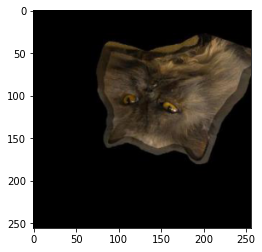

In [19]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model

In [41]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(64)
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(int(64**, 1000),
                                    nn.ReLU())
        
        self.dense2 = nn.Sequential(
                                    nn.Linear(1000,37),
                                    nn.ReLU())
        
        #self.dense3 = nn.Sequential(
                                    #nn.Linear(200,37))
                            
            
    def forward(self,x):
        out = self.conv1(x)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = self.dense2(out)
        #out = self.dense3(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()
learning_rate = 0.000005
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (dense1): Sequential(
    (0): Linear(in_features=125000, out_features=1000, bias=True)
    (1): ReLU()
  )
  (dense2): Sequential(
    (0): Linear(in_features=1000, out_features=37, bias=True)
    (1): ReLU()
  )
)


In [42]:
model.train()    # set the model in training mode coz the batchnorm layer behaves differently when using in eval mode.
num_epochs = 2

start = time.time()

for i in range(num_epochs):
    for images, labels in train_r1_loader:
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            print(name, param.grad.abs().sum())
    
        optimizer.step()
        

    
end = time.time()
print('Time taken: {}'.format(end-start))

conv1.0.weight tensor(9.0081)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.0307)
conv1.2.bias tensor(0.0404)
dense1.0.weight tensor(78755.5938)
dense1.0.bias tensor(0.8804)
dense2.0.weight tensor(93.6995)
dense2.0.bias tensor(0.4006)
conv1.0.weight tensor(5.6980)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.0365)
conv1.2.bias tensor(0.0520)
dense1.0.weight tensor(69706.5312)
dense1.0.bias tensor(0.8879)
dense2.0.weight tensor(92.0112)
dense2.0.bias tensor(0.4276)
conv1.0.weight tensor(6.5970)
conv1.0.bias tensor(0.0001)
conv1.2.weight tensor(0.0806)
conv1.2.bias tensor(0.0962)
dense1.0.weight tensor(70093.6719)
dense1.0.bias tensor(0.8378)
dense2.0.weight tensor(96.5360)
dense2.0.bias tensor(0.4032)
conv1.0.weight tensor(7.1605)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.0891)
conv1.2.bias tensor(0.1278)
dense1.0.weight tensor(62639.0273)
dense1.0.bias tensor(0.8082)
dense2.0.weight tensor(86.4849)
dense2.0.bias tensor(0.3445)
conv1.0.weight tensor(12.0641)
conv1

conv1.0.weight tensor(11.1410)
conv1.0.bias tensor(0.0006)
conv1.2.weight tensor(0.0852)
conv1.2.bias tensor(0.0677)
dense1.0.weight tensor(31980.9434)
dense1.0.bias tensor(0.3668)
dense2.0.weight tensor(58.8249)
dense2.0.bias tensor(0.1662)
conv1.0.weight tensor(1.8644)
conv1.0.bias tensor(0.0004)
conv1.2.weight tensor(0.0396)
conv1.2.bias tensor(0.0351)
dense1.0.weight tensor(28188.1465)
dense1.0.bias tensor(0.3566)
dense2.0.weight tensor(57.6760)
dense2.0.bias tensor(0.1565)
conv1.0.weight tensor(4.5336)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.0582)
conv1.2.bias tensor(0.0550)
dense1.0.weight tensor(29799.3281)
dense1.0.bias tensor(0.3780)
dense2.0.weight tensor(52.7415)
dense2.0.bias tensor(0.1521)
conv1.0.weight tensor(10.6559)
conv1.0.bias tensor(0.0005)
conv1.2.weight tensor(0.0567)
conv1.2.bias tensor(0.0641)
dense1.0.weight tensor(34252.4141)
dense1.0.bias tensor(0.4802)
dense2.0.weight tensor(69.2920)
dense2.0.bias tensor(0.2113)
conv1.0.weight tensor(9.2245)
conv

conv1.0.weight tensor(10.0650)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.0944)
conv1.2.bias tensor(0.1456)
dense1.0.weight tensor(30526.5957)
dense1.0.bias tensor(0.3977)
dense2.0.weight tensor(67.5346)
dense2.0.bias tensor(0.1756)
conv1.0.weight tensor(4.6757)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.1139)
conv1.2.bias tensor(0.1248)
dense1.0.weight tensor(24137.5391)
dense1.0.bias tensor(0.3186)
dense2.0.weight tensor(55.8072)
dense2.0.bias tensor(0.1428)
conv1.0.weight tensor(16.9936)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.1311)
conv1.2.bias tensor(0.1203)
dense1.0.weight tensor(28957.9375)
dense1.0.bias tensor(0.3198)
dense2.0.weight tensor(51.0608)
dense2.0.bias tensor(0.1166)
conv1.0.weight tensor(3.6424)
conv1.0.bias tensor(0.0004)
conv1.2.weight tensor(0.0409)
conv1.2.bias tensor(0.0461)
dense1.0.weight tensor(32029.7051)
dense1.0.bias tensor(0.3365)
dense2.0.weight tensor(61.7386)
dense2.0.bias tensor(0.1364)
conv1.0.weight tensor(25.1395)
con

conv1.0.weight tensor(34.1327)
conv1.0.bias tensor(0.0005)
conv1.2.weight tensor(0.1025)
conv1.2.bias tensor(0.1273)
dense1.0.weight tensor(32136.4980)
dense1.0.bias tensor(0.4730)
dense2.0.weight tensor(79.7849)
dense2.0.bias tensor(0.2057)
conv1.0.weight tensor(9.7531)
conv1.0.bias tensor(0.0009)
conv1.2.weight tensor(0.0828)
conv1.2.bias tensor(0.0823)
dense1.0.weight tensor(29355.7148)
dense1.0.bias tensor(0.2992)
dense2.0.weight tensor(63.5932)
dense2.0.bias tensor(0.1356)
conv1.0.weight tensor(15.9986)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.1591)
conv1.2.bias tensor(0.1793)
dense1.0.weight tensor(35815.2500)
dense1.0.bias tensor(0.4313)
dense2.0.weight tensor(82.9428)
dense2.0.bias tensor(0.1908)
conv1.0.weight tensor(30.1388)
conv1.0.bias tensor(7.7405e-05)
conv1.2.weight tensor(0.1359)
conv1.2.bias tensor(0.1733)
dense1.0.weight tensor(36690.2070)
dense1.0.bias tensor(0.4600)
dense2.0.weight tensor(88.7476)
dense2.0.bias tensor(0.1775)
conv1.0.weight tensor(11.5945

conv1.0.weight tensor(25.8543)
conv1.0.bias tensor(0.0004)
conv1.2.weight tensor(0.0649)
conv1.2.bias tensor(0.0822)
dense1.0.weight tensor(33006.5078)
dense1.0.bias tensor(0.3479)
dense2.0.weight tensor(90.2953)
dense2.0.bias tensor(0.1746)
conv1.0.weight tensor(26.2804)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.1520)
conv1.2.bias tensor(0.1960)
dense1.0.weight tensor(32764.2305)
dense1.0.bias tensor(0.4351)
dense2.0.weight tensor(106.5520)
dense2.0.bias tensor(0.2385)
conv1.0.weight tensor(11.6593)
conv1.0.bias tensor(0.0007)
conv1.2.weight tensor(0.1445)
conv1.2.bias tensor(0.1432)
dense1.0.weight tensor(34815.8164)
dense1.0.bias tensor(0.4551)
dense2.0.weight tensor(115.9584)
dense2.0.bias tensor(0.2461)
conv1.0.weight tensor(9.7942)
conv1.0.bias tensor(0.0006)
conv1.2.weight tensor(0.1529)
conv1.2.bias tensor(0.1495)
dense1.0.weight tensor(35223.9062)
dense1.0.bias tensor(0.4195)
dense2.0.weight tensor(107.2742)
dense2.0.bias tensor(0.1973)
conv1.0.weight tensor(23.7661)

conv1.0.weight tensor(21.4422)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.1374)
conv1.2.bias tensor(0.1086)
dense1.0.weight tensor(31927.0254)
dense1.0.bias tensor(0.4163)
dense2.0.weight tensor(115.1787)
dense2.0.bias tensor(0.2402)
conv1.0.weight tensor(7.5337)
conv1.0.bias tensor(0.0004)
conv1.2.weight tensor(0.0900)
conv1.2.bias tensor(0.0752)
dense1.0.weight tensor(30884.8594)
dense1.0.bias tensor(0.3391)
dense2.0.weight tensor(95.0450)
dense2.0.bias tensor(0.1510)
conv1.0.weight tensor(19.4450)
conv1.0.bias tensor(0.0003)
conv1.2.weight tensor(0.0716)
conv1.2.bias tensor(0.0635)
dense1.0.weight tensor(28620.1602)
dense1.0.bias tensor(0.2838)
dense2.0.weight tensor(72.8513)
dense2.0.bias tensor(0.1315)
conv1.0.weight tensor(41.5038)
conv1.0.bias tensor(0.0011)
conv1.2.weight tensor(0.1267)
conv1.2.bias tensor(0.0752)
dense1.0.weight tensor(31349.3477)
dense1.0.bias tensor(0.3173)
dense2.0.weight tensor(92.1747)
dense2.0.bias tensor(0.1428)
conv1.0.weight tensor(9.4051)
co

conv1.0.weight tensor(23.6515)
conv1.0.bias tensor(0.0008)
conv1.2.weight tensor(0.1320)
conv1.2.bias tensor(0.1824)
dense1.0.weight tensor(37788.7422)
dense1.0.bias tensor(0.4440)
dense2.0.weight tensor(134.4448)
dense2.0.bias tensor(0.2220)
conv1.0.weight tensor(12.1948)
conv1.0.bias tensor(0.0005)
conv1.2.weight tensor(0.2904)
conv1.2.bias tensor(0.3534)
dense1.0.weight tensor(41405.7031)
dense1.0.bias tensor(0.5059)
dense2.0.weight tensor(155.7048)
dense2.0.bias tensor(0.2530)
conv1.0.weight tensor(12.1966)
conv1.0.bias tensor(0.0005)
conv1.2.weight tensor(0.1255)
conv1.2.bias tensor(0.1321)
dense1.0.weight tensor(38118.6602)
dense1.0.bias tensor(0.4443)
dense2.0.weight tensor(150.7220)
dense2.0.bias tensor(0.2252)
conv1.0.weight tensor(18.7935)
conv1.0.bias tensor(0.0002)
conv1.2.weight tensor(0.1767)
conv1.2.bias tensor(0.1795)
dense1.0.weight tensor(29561.2617)
dense1.0.bias tensor(0.3462)
dense2.0.weight tensor(100.2989)
dense2.0.bias tensor(0.1748)
conv1.0.weight tensor(29.818

In [43]:
model.eval()

with torch.no_grad():
    for images, labels in valid_loader:
        out = model(images.float())
        print(out.shape)
        print(out)
        print(torch.max(out,1)[1]==labels)
                    

torch.Size([64, 37])
tensor([[-3.1791, -3.6489, -3.6489,  ..., -3.6489, -3.6489, -3.6489],
        [-3.6871, -2.8780, -3.6871,  ..., -3.4649, -3.6871, -3.6871],
        [-3.7575, -3.7575, -3.7575,  ..., -3.0119, -3.7575, -3.7575],
        ...,
        [-3.9416, -3.9416, -3.9416,  ..., -3.9416, -3.9416, -3.9416],
        [-3.6606, -3.2834, -3.6606,  ..., -3.6606, -3.6606, -3.6606],
        [-3.6903, -2.9969, -3.6903,  ..., -3.1430, -3.6903, -3.6903]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.8843, -

torch.Size([64, 37])
tensor([[-3.7396, -3.7396, -3.7396,  ..., -3.5832, -3.7396, -3.7396],
        [-3.8796, -3.0407, -3.8796,  ..., -2.6993, -3.8796, -3.8796],
        [-3.6134, -3.6134, -3.6134,  ..., -3.6134, -3.6134, -3.6134],
        ...,
        [-3.8346, -2.5754, -3.8346,  ..., -2.9810, -3.8346, -3.8346],
        [-3.7461, -3.7352, -3.7461,  ..., -2.7076, -3.7461, -3.7461],
        [-3.9877, -3.9877, -3.9877,  ..., -3.4358, -3.9877, -3.9877]])
tensor([False,  True, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False, False, False,
         True, False,  True,  True])
torch.Size([64, 37])
tensor([[-3.7031, -

torch.Size([64, 37])
tensor([[-3.8470, -1.8390, -3.8470,  ..., -3.8470, -3.8470, -3.8470],
        [-3.3535, -3.6704, -3.6704,  ..., -3.6363, -3.6704, -3.6704],
        [-3.8530, -3.1564, -3.8530,  ..., -2.6238, -3.8530, -3.8530],
        ...,
        [-3.9105, -2.8268, -3.9105,  ..., -3.9105, -3.9105, -3.9105],
        [-4.3640, -2.0078, -4.3640,  ..., -4.3640, -4.3640, -4.3640],
        [-3.8693, -1.8964, -3.8693,  ..., -2.9599, -3.8693, -3.8693]])
tensor([ True, False, False, False, False, False, False,  True, False,  True,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False])
torch.Size([64, 37])
tensor([[-3.7765, -